##Getting the data
Before building a model we need a data on which we can train a model. For this Architecture we are going to the image net dataset.

Note: In this notebook we will firstly leverage the fastai library a high level library build upon the PyTorch.

In [68]:
from fastai.vision.all import *

In [69]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
      blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
      splitter=GrandparentSplitter(valid_name='val'),
      get_y=parent_label, item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                  Normalize.from_stats(*imagenet_stats)]

  ).dataloaders(path, bs=128)

In [70]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

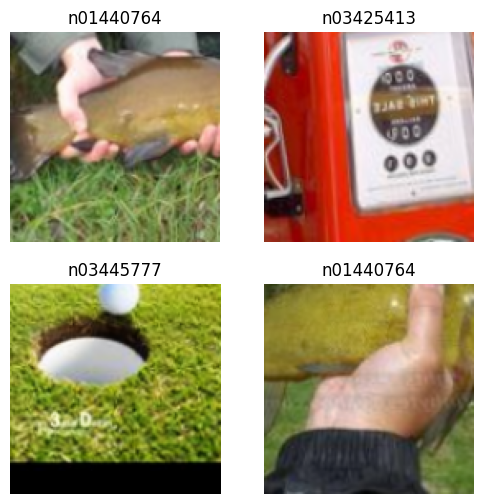

In [71]:
dls.show_batch(max_n=4)

# The Residual Block
The resnet architecture leverage the concept of skip connection.

At first we will create the class defition for the **ResBlock** and the componenets inside of it.

In [72]:
def _conv_block(ni, nf, stride):
  return nn.Sequential(
      ConvLayer(ni, nf, stride=stride),
      ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero),
  )

A Skip Connection (or Shortcut Connection) is a fundamental element of the Residual Block used in ResNet (Residual Network) architectures.
#Skip Connection
A Skip Connection is an identity function that routes the original input data, $x$, directly across one or more layers, bypassing them completely. The output of this path is then added element-wise to the output of the layer(s) it skipped ($\mathcal{F}(x)$). This forces the layer(s) to learn only the residual mapping ($\mathcal{F}(x)$), or the necessary adjustment, instead of the entire required transformation. This structure guarantees that if the layer isn't needed, it can easily learn to output zero ($\mathcal{F}(x) \to 0$), effectively turning the block into an identity function ($\mathcal{F}(x) + x \to x$). This allows neural networks to be built much deeper by solving the problems of vanishing gradients and performance degradation.

In [73]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        self.idConv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) # Handle the channels
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # Handle the spatial dimensions

    def forward(self, x):
        return F.relu(self.convs(x) + self.idConv(self.pool(x)))

In the skip connection we preserved the Original output but it is all possible that after the transformation the size and shape of the x (original input) might get changes to deal with it. we can do two things:

1. To handle the changes in feature we can perform a 1 X 1 convolution to ensure that the image doesn't get reduced a lot.
2. To handle the change in spatial dimension we can perform an avg pool on the image to reduce the spatial dimension. It can be useful when the layer transformation involves the stride 2 conv so that you can also apply the stride 2 avg pool on the orignal input to reduce the size by the factor of 2.


In [74]:
def block(ni,nf): return ResBlock(ni,nf, stride=2)

In [75]:
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [76]:
learn = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.304690,2.229080,0.185987,00:19
1,2.157612,2.073460,0.299363,00:18
2,2.054933,2.004170,0.325096,00:19
3,1.998308,1.980582,0.336815,00:18
4,1.977306,1.972224,0.337070,00:19


the above was the demonstration of the residual block combined with a fully convolution network. now in the further section we will implement the SOTA Resnet model.

# State of the art Resnet Model
## 🏗️ The ResNet Stem: Initial Heavy Lifting

The first few layers of a ResNet are composed of **plain convolutional layers** and pooling, collectively known as the **Stem** of the ResNet model.

We implement the Stem to perform several critical functions right at the start:

1.  **Drastically Reduce Spatial Dimensions:** The Stem uses a large kernel size and/or multiple stride=2 operations to rapidly shrink the height and width of the input image (e.g., reduction factor of 4).
2.  **Increase Feature Size (Channels):** The Stem expands the channel count (e.g., from 3 to 64) to build initial feature capacity.
3.  **Learn Basic Features:** The Stem efficiently extracts basic, low-level features before the deeper blocks take over.

The reason we use **plain convolutions** instead of Residual Blocks at this stage is that the Stem's job requires rapid, large, **non-linear structural transformations** (heavy compression and expansion). Residual Blocks are optimized for *refining* features at a fixed resolution, not for these initial, drastic structural changes.

In [77]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], ks=3, stride=2, padding=1)
        for i in range(len(sizes) - 1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [78]:
_resnet_stem(3, 32, 32, 64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

### Resnet Model

In [79]:
class ResNet(nn.Sequential):
    def __init__(self, in_out, layers, expansion=1):
        stem = _resnet_stem(3, 32, 32, 64)
        self.channels = [64, 64, 128, 256, 512]
        for i in range(1, 5): self.channels[i] *= expansion
        # Build the residual block layers
        blocks = [self._make_layers(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                        nn.AdaptiveAvgPool2d(1),
                        Flatten(),
                        nn.Linear(self.channels[-1],in_out))

    def _make_layers(self, idx, o_layers):
        stride = 1 if idx==0 else 2
        in_ch, out_ch = self.channels[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(in_ch if i==0 else out_ch, out_ch, stride if i==0 else 1)
            for i in range(o_layers)
        ])

In [80]:
model = ResNet(dls.c, [2,2,2,2])

In [ ]:
model

In [82]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.297596,2.167098,0.233121,00:18
1,2.045260,1.928043,0.340382,00:19
2,1.897513,1.838410,0.380637,00:18
3,1.818419,1.807415,0.395159,00:19
4,1.785405,1.795087,0.402803,00:18


### Bottle Neck Layer

A Bottleneck Block is a highly efficient variation of the Residual Block used in deep neural networks (e.g., ResNet-50 and deeper) to reduce computational cost.

Instead of the 2 convolutional layers used in the Basic Block, the Bottleneck Block uses a sequence of 3 convolutional layers:
1. $1 \times 1$ Convolution (Squeeze): This layer drastically reduces the number of channels (e.g., by a factor of 4), creating a narrow "bottleneck."
2. $3 \times 3$ Convolution (Process): This layer performs the main feature learning, but does so on the reduced channel count, significantly saving on computation.
3. $1 \times 1$ Convolution (Expand): This layer restores the channel count back to the original depth so the result can be added to the input via the skip connection.

In [83]:
def _conv_block(ni, nf, stride=2):
    return nn.Sequential(
        ConvLayer(ni, nf//4, ks=1),
        ConvLayer(nf//4, nf//4, stride=stride),
        ConvLayer(nf//4, nf, act_cls=None, norm_type=NormType.BatchZero)
    )

Expansion refers to the proportion by which you squeeze the features so that you can apply the number of filters


In [84]:
model = ResNet(dls.c, [3,4,6,3], 4)

In [85]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.007585775572806597)

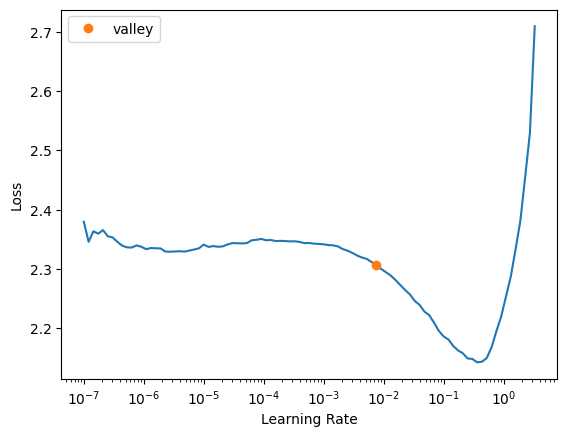

In [86]:
learn.lr_find()

In [ ]:
learn.model

In [88]:
learn.fit_one_cycle(20, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.087188,1.946931,0.331720,00:22
1,1.813465,1.693429,0.431592,00:21
2,1.580201,1.619848,0.448917,00:21
3,1.458452,1.486283,0.501401,00:22
4,1.384857,1.415485,0.534777,00:20
5,1.345607,1.556433,0.476943,00:21
6,1.303011,1.615606,0.464204,00:21
7,1.272498,1.443261,0.520255,00:20
8,1.250337,1.286126,0.574013,00:21
9,1.211441,1.227620,0.591083,00:22
